***
# <font color='dodgerblue'>DNMT Performance/condition given experience during the stimulation protocol
***   
####  We are testing the prediction that silencing CG (either during choice or sample) will decrease NpHR rats' performance. 

#### We will analyze the performance levels in both experimental groups at three time points across sessions:
#### from trial 0 to 50 per condition; 50 to 100 and 100 to 150.
***

## <font color='firebrick'>Imports
***

In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import scipy.stats as stats
import os
import re
from file_lists import get_file_list
%matplotlib inline

## <font color='firebrick'>Inputs
***

In [46]:
# Collect trial data for each experimental group
ctrl_dir="E:\PERFORMANCE_LOGS\\CTRL"
nphr_dir="E:\PERFORMANCE_LOGS\\NPHR"

## <font color='firebrick'>Functions
***

In [47]:
def collect_trial_data(folder_dir):
    
    '''
    Created a function to collect all trials from all rats of given experimental group. 
    For each rat and stimulation condition, add a trial number from 1 to n, being n the total 
    number of trials per condition for each rat.
    '''
      
    # Get directories of each rat folder inside group folder (condition folders: CTRL, EXP)
    rat_folders = os.listdir(folder_dir)
    rat_dirs = [os.path.join(folder_dir, x) for x in rat_folders]
  
    # For each subject, collect trial data
    data = []
    
    for path in rat_dirs:
    
        id = re.search(r"(\w+\d)", path)
        file_list = get_file_list(path, '*.csv')
        file_list.sort()
        all_sessions_list = []
        
        # Collect data in the form of a dataframe from every single file the rat folder
        for filename in file_list:
            
            session = pd.read_csv(os.path.join(path, filename), 
                                  names=['sample', 'stim', 'outcome'], 
                                  header=None)    
            
            # Add the session label to the 'session' column in the dataframe
            session_code = re.search(r"_(\d+).", filename)
            session['session'] = session_code[1]
            
            try:
                all_sessions_list.append(session)
            except:
                all_sessions_list = session
        
        all_sessions_rat = pd.concat(all_sessions_list)
        all_sessions_rat['rat'] = id[0]

        # Add a trial number given the stimulation condition
        for cond in all_sessions_rat['stim'].unique():
            
            trial_numbers = list(range(1,len(all_sessions_rat[all_sessions_rat['stim'] == cond])+1))
            all_sessions_rat.loc[all_sessions_rat['stim'] == cond, 'trial_nr_stim'] = trial_numbers
            
        try:
            data.append(all_sessions_rat)
        except:
            data = all_sessions_rat
                      
    return pd.concat(data)


def calculate_partitioned_performance(groupby_object, group):
    
    '''
    
    Calculate the performance across the stim protocol. Group the trials by rat and stimulation condition. 
    Then, for each group, groupby again by the number of rows (df.index / N). For each, count the total 
    number of trials and sum the correct trials (df['outcome'] ==1). Store each type of information into 
    two dataframes ('sums' and 'total') and divide, thus calculating the partitioned performance. 
    These will be labeled with the corresponding rat name, experimental group and stimulation condition. 
    All these dataframes will be concatenated into one.
    
    '''
    
    df = groupby_object.get_group(group)
    N=50
    
    df.index = range(len(df))
    # Divide the number of rows in each group (rat x stim) by N. 
    # Then either sum the correct trials (outcome==1) or count the total number of trials
    sums = df['outcome'].groupby(df.index//N).sum()
    total = df['outcome'].groupby(df.index//N).count()
    
    # Calculate partitioned performance by dividing the "sums" and "total" dataframes
    # Attirbute the rat  group and condition label to each performance in the new par_perf dataframe
    par_perf = ((sums/total)*100).to_frame()
    par_perf['group'] = group[0]
    par_perf['rat'] = group[1] 
    par_perf['stim']= group[2]
  
    return par_perf


## <font color='mediumseagreen'> Collect the trials from each animal and number them from the start until the end of the protocol
***

In [48]:
ctrl_trials = collect_trial_data(ctrl_dir)
nphr_trials = collect_trial_data(nphr_dir)

# Add experimental group label and concatenate both dataframes into one
ctrl_trials['group'] = 'control'
nphr_trials['group'] = 'nphr'

trials = pd.concat([ctrl_trials, nphr_trials])
print('TOTAL NUMBER OF TRIALS PER EXPERIMENTAL GROUP:\n'+str(trials['group'].value_counts()))

TOTAL NUMBER OF TRIALS PER EXPERIMENTAL GROUP:
nphr       3416
control    2028
Name: group, dtype: int64


## <font color='mediumseagreen'> Calculate the average performance during the pre-stimulation (NpHR group)

In [49]:
# Collect pre-stimulation average performance for the nphr group -- to use in the plot
prestim=trials[trials['stim']==-1]

prestim_nphr = prestim[prestim['group']=='nphr']
prestim_nphr_perf = (prestim_nphr['outcome'].sum()/len(prestim_nphr))

## <font color='mediumseagreen'> Remove pre-stimulation trials and other stimulation conditions from the pilot study

In [50]:
#Remove trials in which the rat was stimulated during delay or pre-stimulation
conditions_to_keep_mask = ((trials['stim'].between(0,1)) | (trials['stim'] == 3))
trials = trials[conditions_to_keep_mask]

#Remove trials from NpHR#3
trials = trials[trials['rat']!='SONECA_NPHR3']

## <font color='mediumseagreen'> Calculate the performance across trial blocks

In [52]:
grouped_trials = trials.groupby(['group','rat', 'stim'])

group_list = []
for group in grouped_trials.groups:
    par_perf_group = calculate_partitioned_performance(grouped_trials, group)
    try:
        group_list.append(par_perf_group)
    except:
        group_list = par_perf_group
        
par_perf = pd.concat(group_list)

,outcome,group,rat,stim
0,86.000000,control,BRIOSA_CTRL3,0.0
1,84.000000,control,BRIOSA_CTRL3,0.0
2,81.632653,control,BRIOSA_CTRL3,0.0
0,80.000000,control,BRIOSA_CTRL3,1.0
1,78.000000,control,BRIOSA_CTRL3,1.0
...,...,...,...,...
2,76.000000,nphr,ZEUS_NPHR5,1.0
3,100.000000,nphr,ZEUS_NPHR5,1.0
0,78.000000,nphr,ZEUS_NPHR5,3.0
1,74.000000,nphr,ZEUS_NPHR5,3.0



# 1.
***
### Comparing the performance across trials within the NpHR group, for the three stimulation conditions
***

['ARES_NPHR8' 'DUNGA_NPHR2' 'FELIZ_NPHR1' 'HEFESTO_NPHR4' 'HERCULES_NPHR6'
 'RAMBO_NPHR7' 'ZEUS_NPHR5']


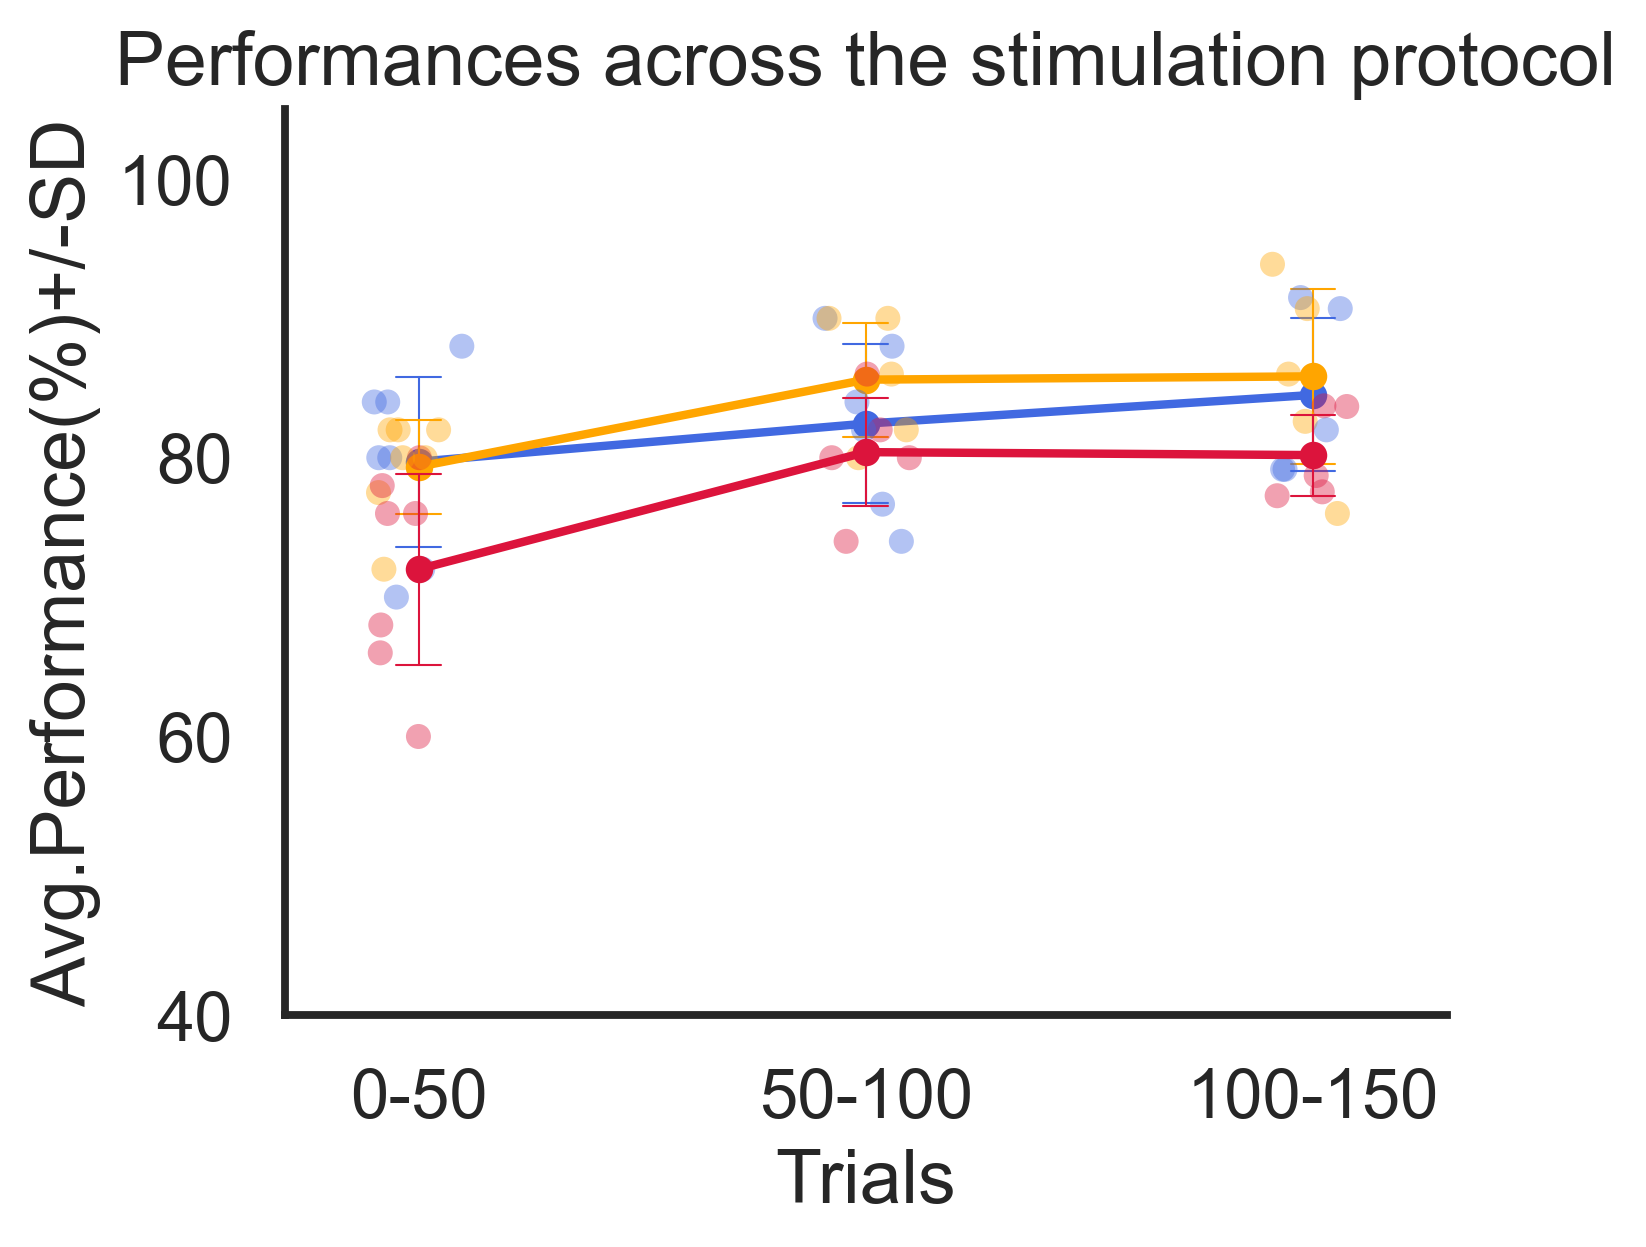

In [36]:
df = par_perf[par_perf['group'] == 'nphr'].drop(index=[3])
#df = df.drop(index=[5])

print(df['rat'].unique())
sns.set(style="white", context='talk')
plt.figure(figsize=(5,4), dpi=300)

g = sns.stripplot(
    x=df.index, y='outcome', hue='stim', data=df,
    palette=['royalblue', 'orange', 'crimson'],
    jitter=.1, alpha=.4, s=6
)
    
# Show means. 1st color=0, 2nd color=sample, 3rd color=test
sns.pointplot(
    x=df.index, y='outcome', hue='stim', data=df, 
    dodge=False, join=True,            
    markers="o", scale=.5,  alpha=.7,
    ci='sd', errwidth=.5, capsize=.1,
    palette=['royalblue', 'orange', 'crimson']
)

g.set(
    xlim=(-0.3,2.3), ylim=(40,105),
    ylabel='Avg.Performance(%)+/-SD', xlabel='Trials',
    title='Performances across the stimulation protocol'
)

g.set_xticklabels(['0-50', '50-100', '100-150'], rotation=0)
g.legend_.remove()
sns.despine()
plt.show()


# 2.

***
### Comparing the performance across trials within the NpHR group, for 'No stim' and 'Choice/Test Stim' conditions
***

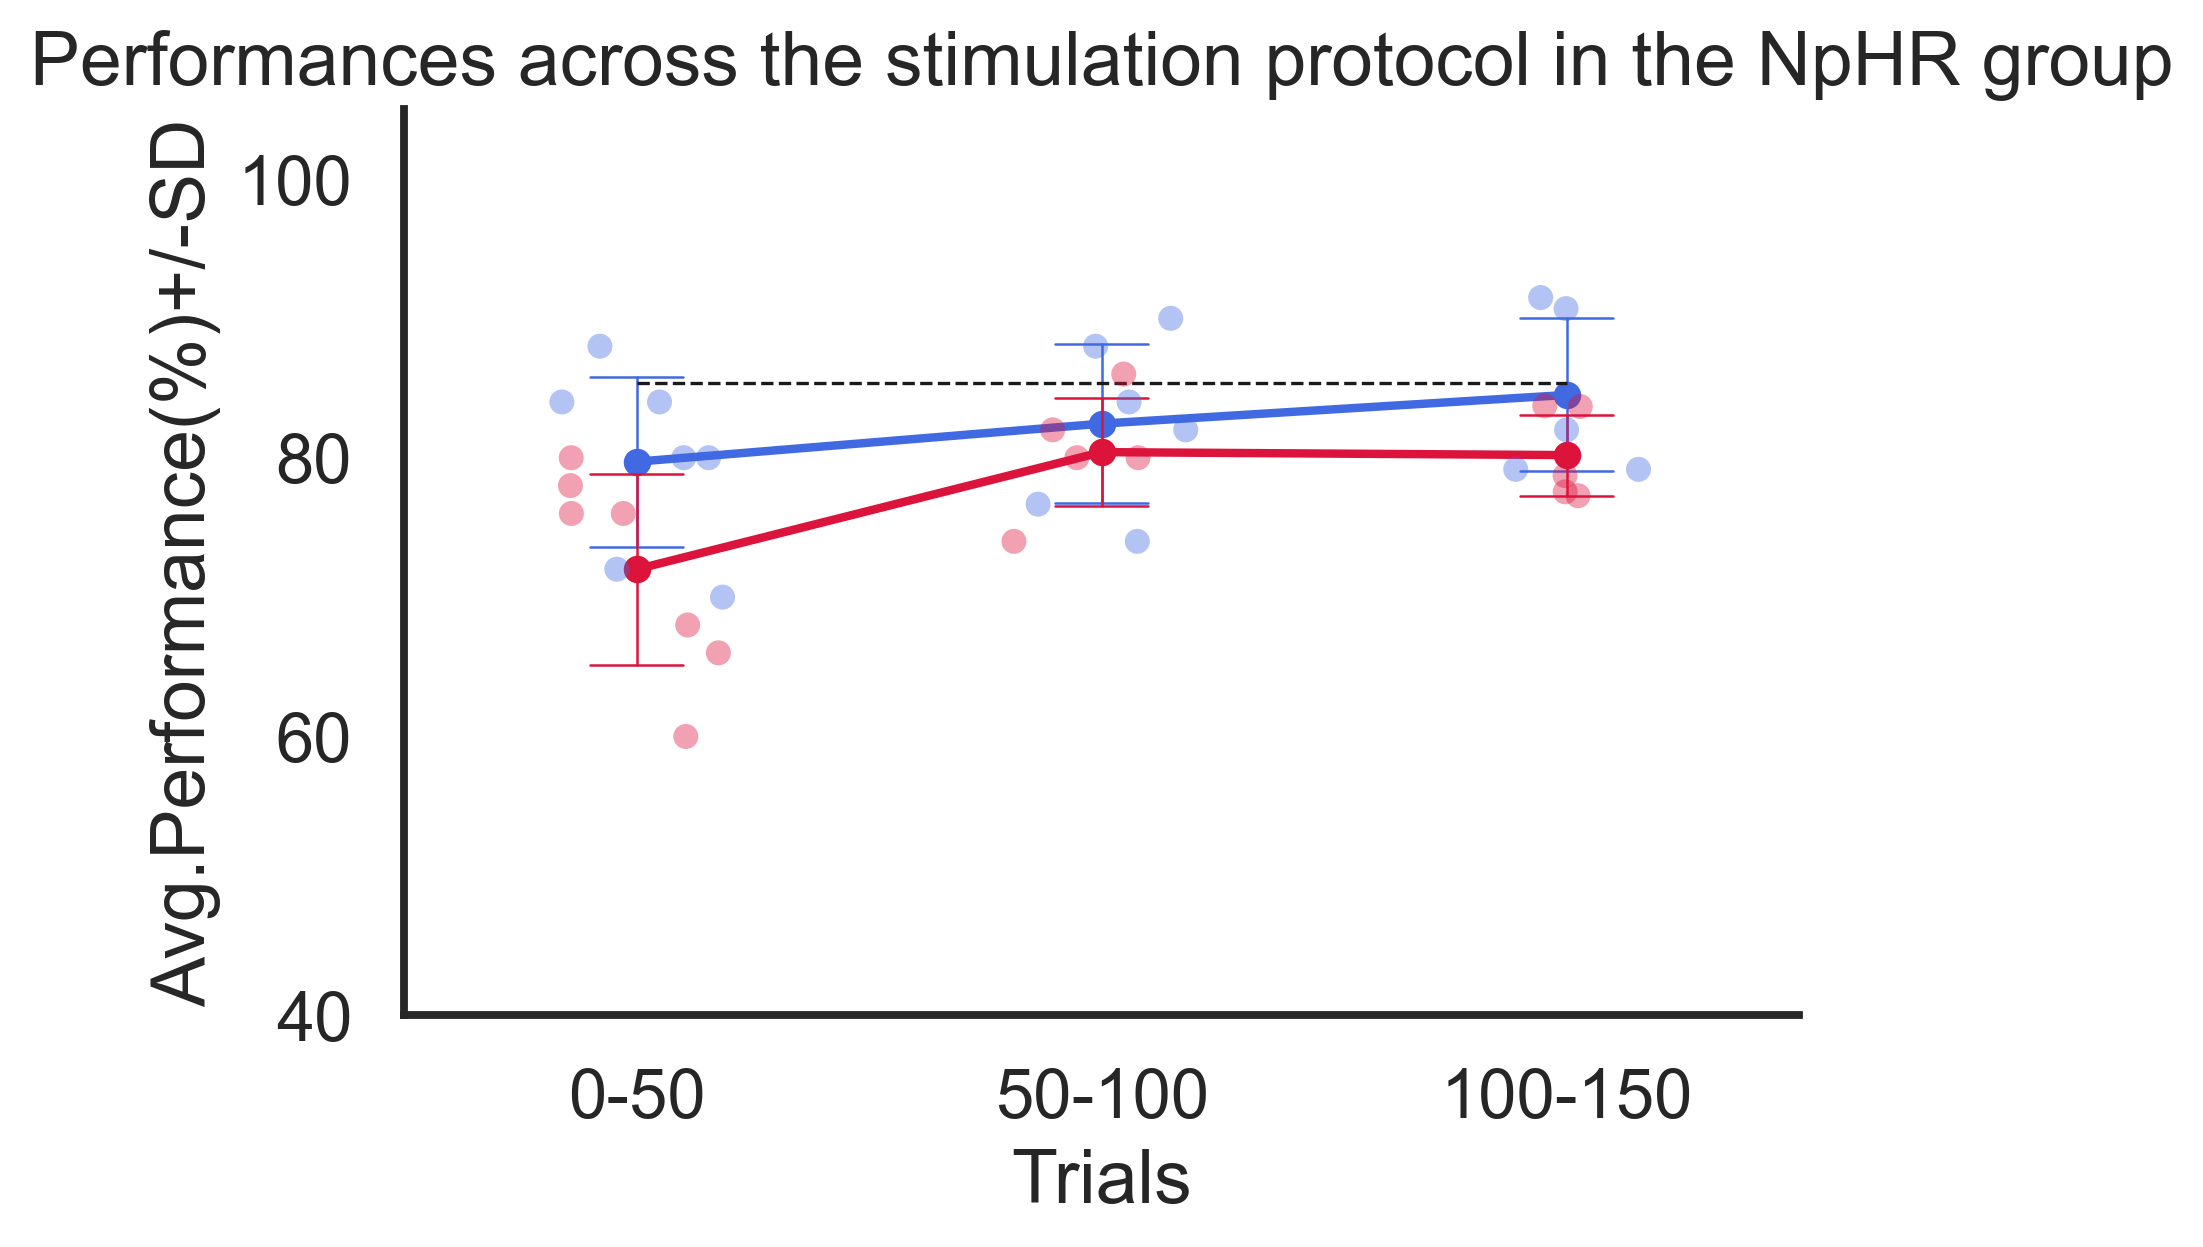

In [37]:
df = par_perf[par_perf['group'] == 'nphr']
df = df[df['stim']!=1].drop(index=[3])

    
sns.set(style="white", context='talk')
plt.figure(figsize=(6,4), dpi=300)

g = sns.stripplot(
    x=df.index, y='outcome', hue='stim', data=df,
    palette=['royalblue', 'crimson'],
    jitter=.2, alpha=.4, s=6
)
    
# Show means. 1st color=0, 2nd color=sample, 3rd color=test
sns.pointplot(
    x=df.index, y='outcome', hue='stim', data=df, 
    dodge=False, join=True,            
    markers="o", scale=.5,  alpha=.7,
    ci='sd', errwidth=.6, capsize=.2,
    palette=['royalblue', 'crimson']
)

plt.plot(range(3),[prestim_nphr_perf*100]*3, '--k', linewidth=.8)


g.set(
    xlim=(-0.5,2.5), ylim=(40,105),
    ylabel='Avg.Performance(%)+/-SD', xlabel='Trials',
    title='Performances across the stimulation protocol in the NpHR group'
)

g.set_xticklabels(['0-50', '50-100', '100-150'])
g.legend_.remove()
sns.despine()
plt.show()

# 3.
***
### Comparing the performance across trials within the NpHR group, for 'No stim' and 'Sample Stim' conditions
***

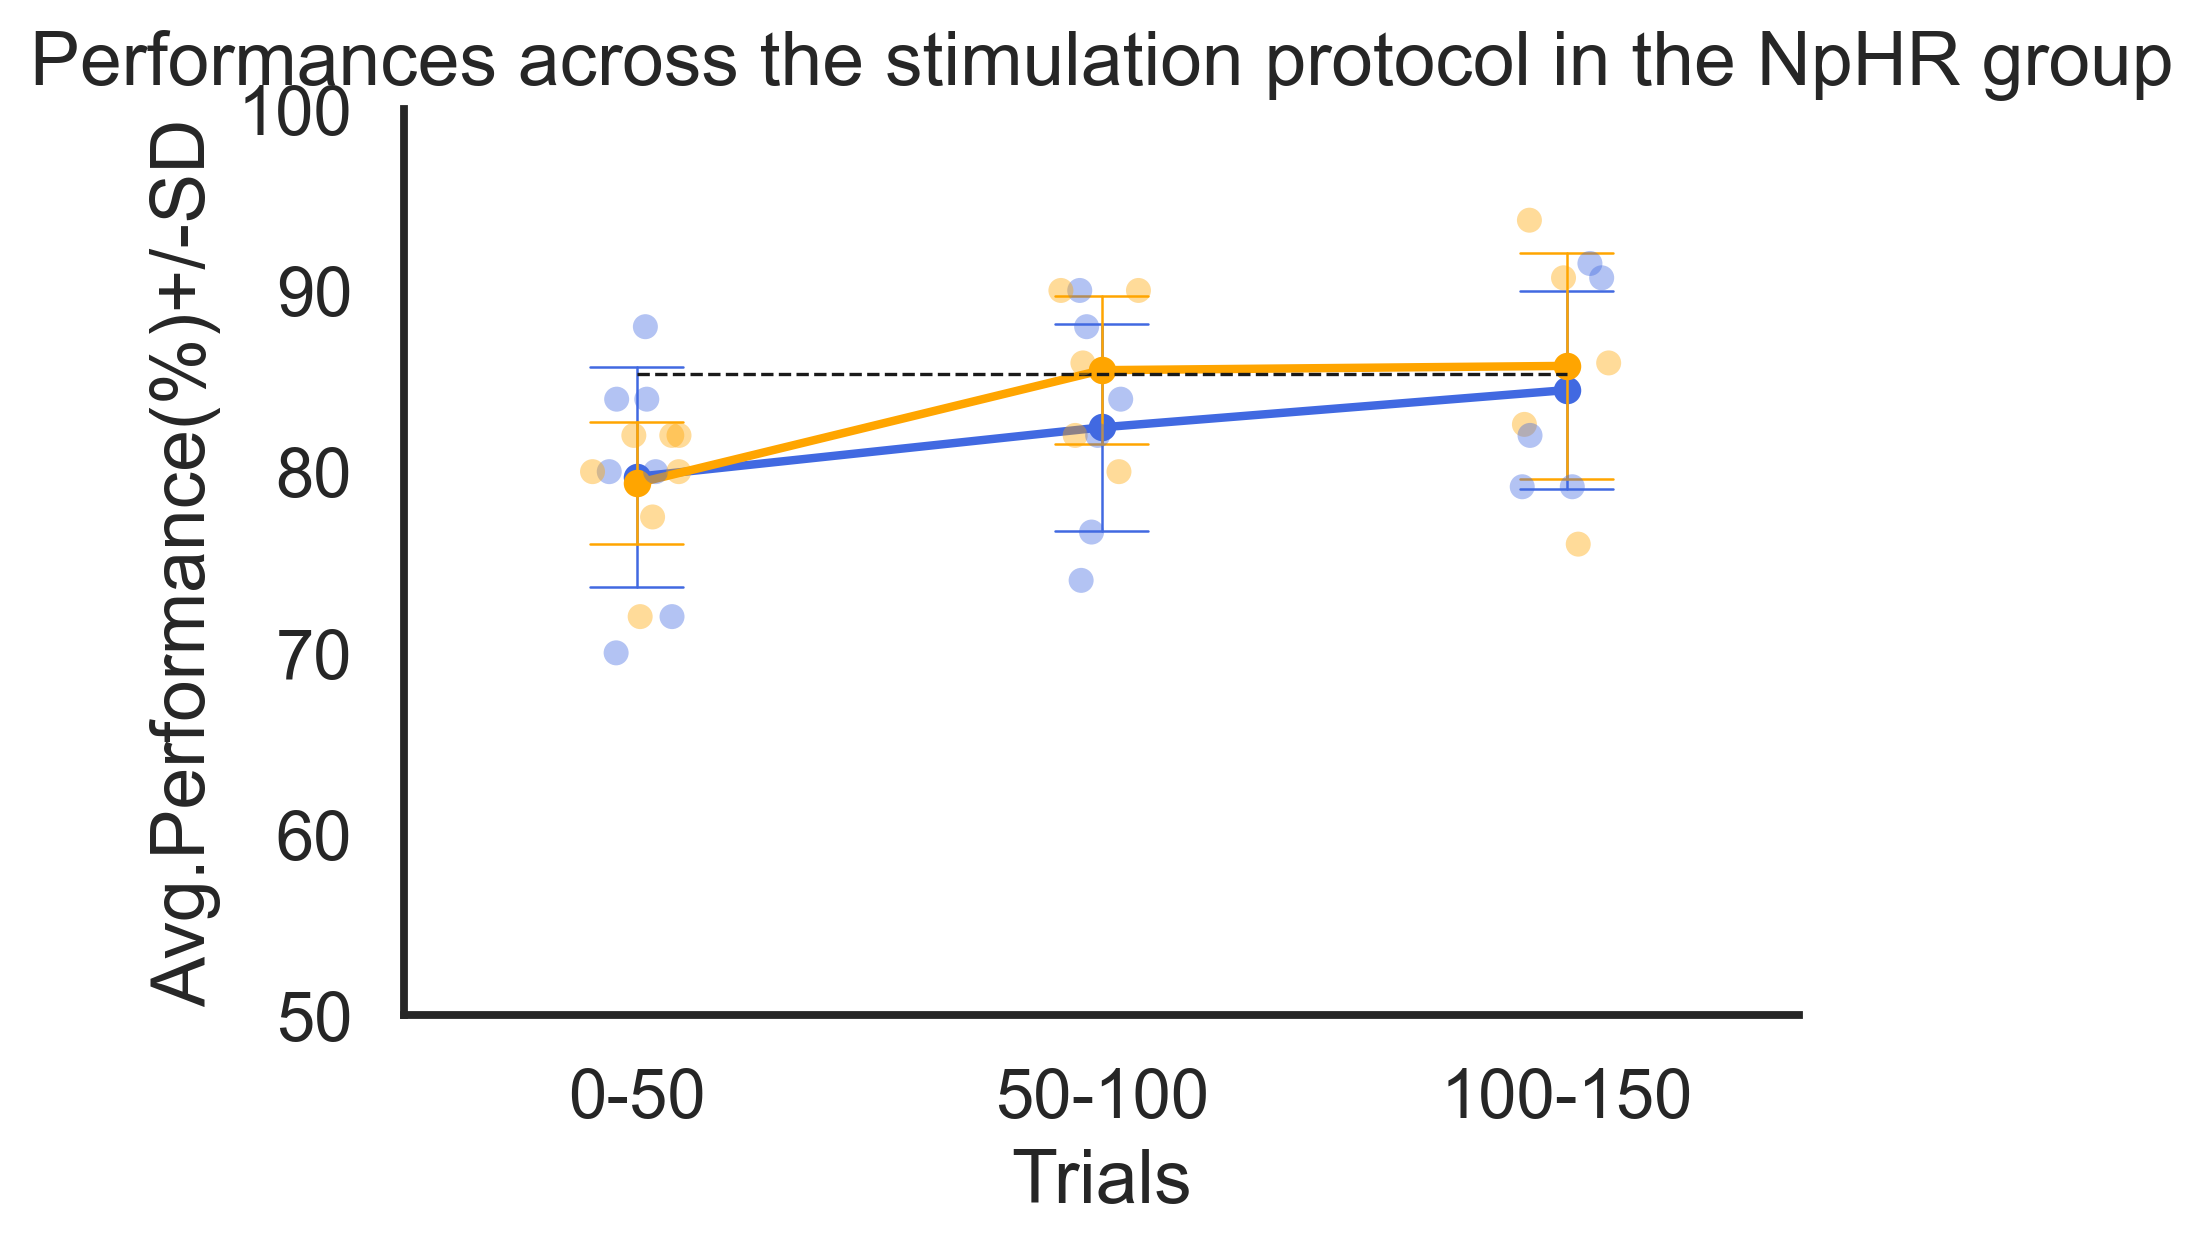

In [38]:
df = par_perf[par_perf['group'] == 'nphr']
df = df[df['stim']!=3].drop(index=[3])

    
sns.set(style="white", context='talk')
plt.figure(figsize=(6,4), dpi=300)

g = sns.stripplot(
    x=df.index, y='outcome', hue='stim', data=df,
    palette=['royalblue', 'orange'],
    jitter=.1, alpha=.4, s=6
)
    
# Show means. 1st color=0, 2nd color=sample, 3rd color=test
a=sns.pointplot(
    x=df.index, y='outcome', hue='stim', data=df, 
    dodge=False, join=True,            
    markers="o", scale=.5,  alpha=.7,
    ci='sd', errwidth=.6, capsize=.2,
    palette=['royalblue', 'orange'], legend=True
)

plt.plot(range(3),[prestim_nphr_perf*100]*3, '--k', linewidth=.8)


g.set(
    xlim=(-0.5,2.5), ylim=(50,100),
    ylabel='Avg.Performance(%)+/-SD', xlabel='Trials',
    title='Performances across the stimulation protocol in the NpHR group'
)

g.set_xticklabels(['0-50', '50-100', '100-150'])
g.legend_.remove()
sns.despine()
plt.show()

# 4.
***
### Comparing the performance across trials during CG silencing for both groups - control and NpHR
***

['BRIOSA_CTRL3' 'DENGOSO_CTRL2' 'MESTRE_CTRL1' 'ROCKY_CTRL6' 'ARES_NPHR8'
 'DUNGA_NPHR2' 'FELIZ_NPHR1' 'HEFESTO_NPHR4' 'HERCULES_NPHR6'
 'RAMBO_NPHR7' 'ZEUS_NPHR5']


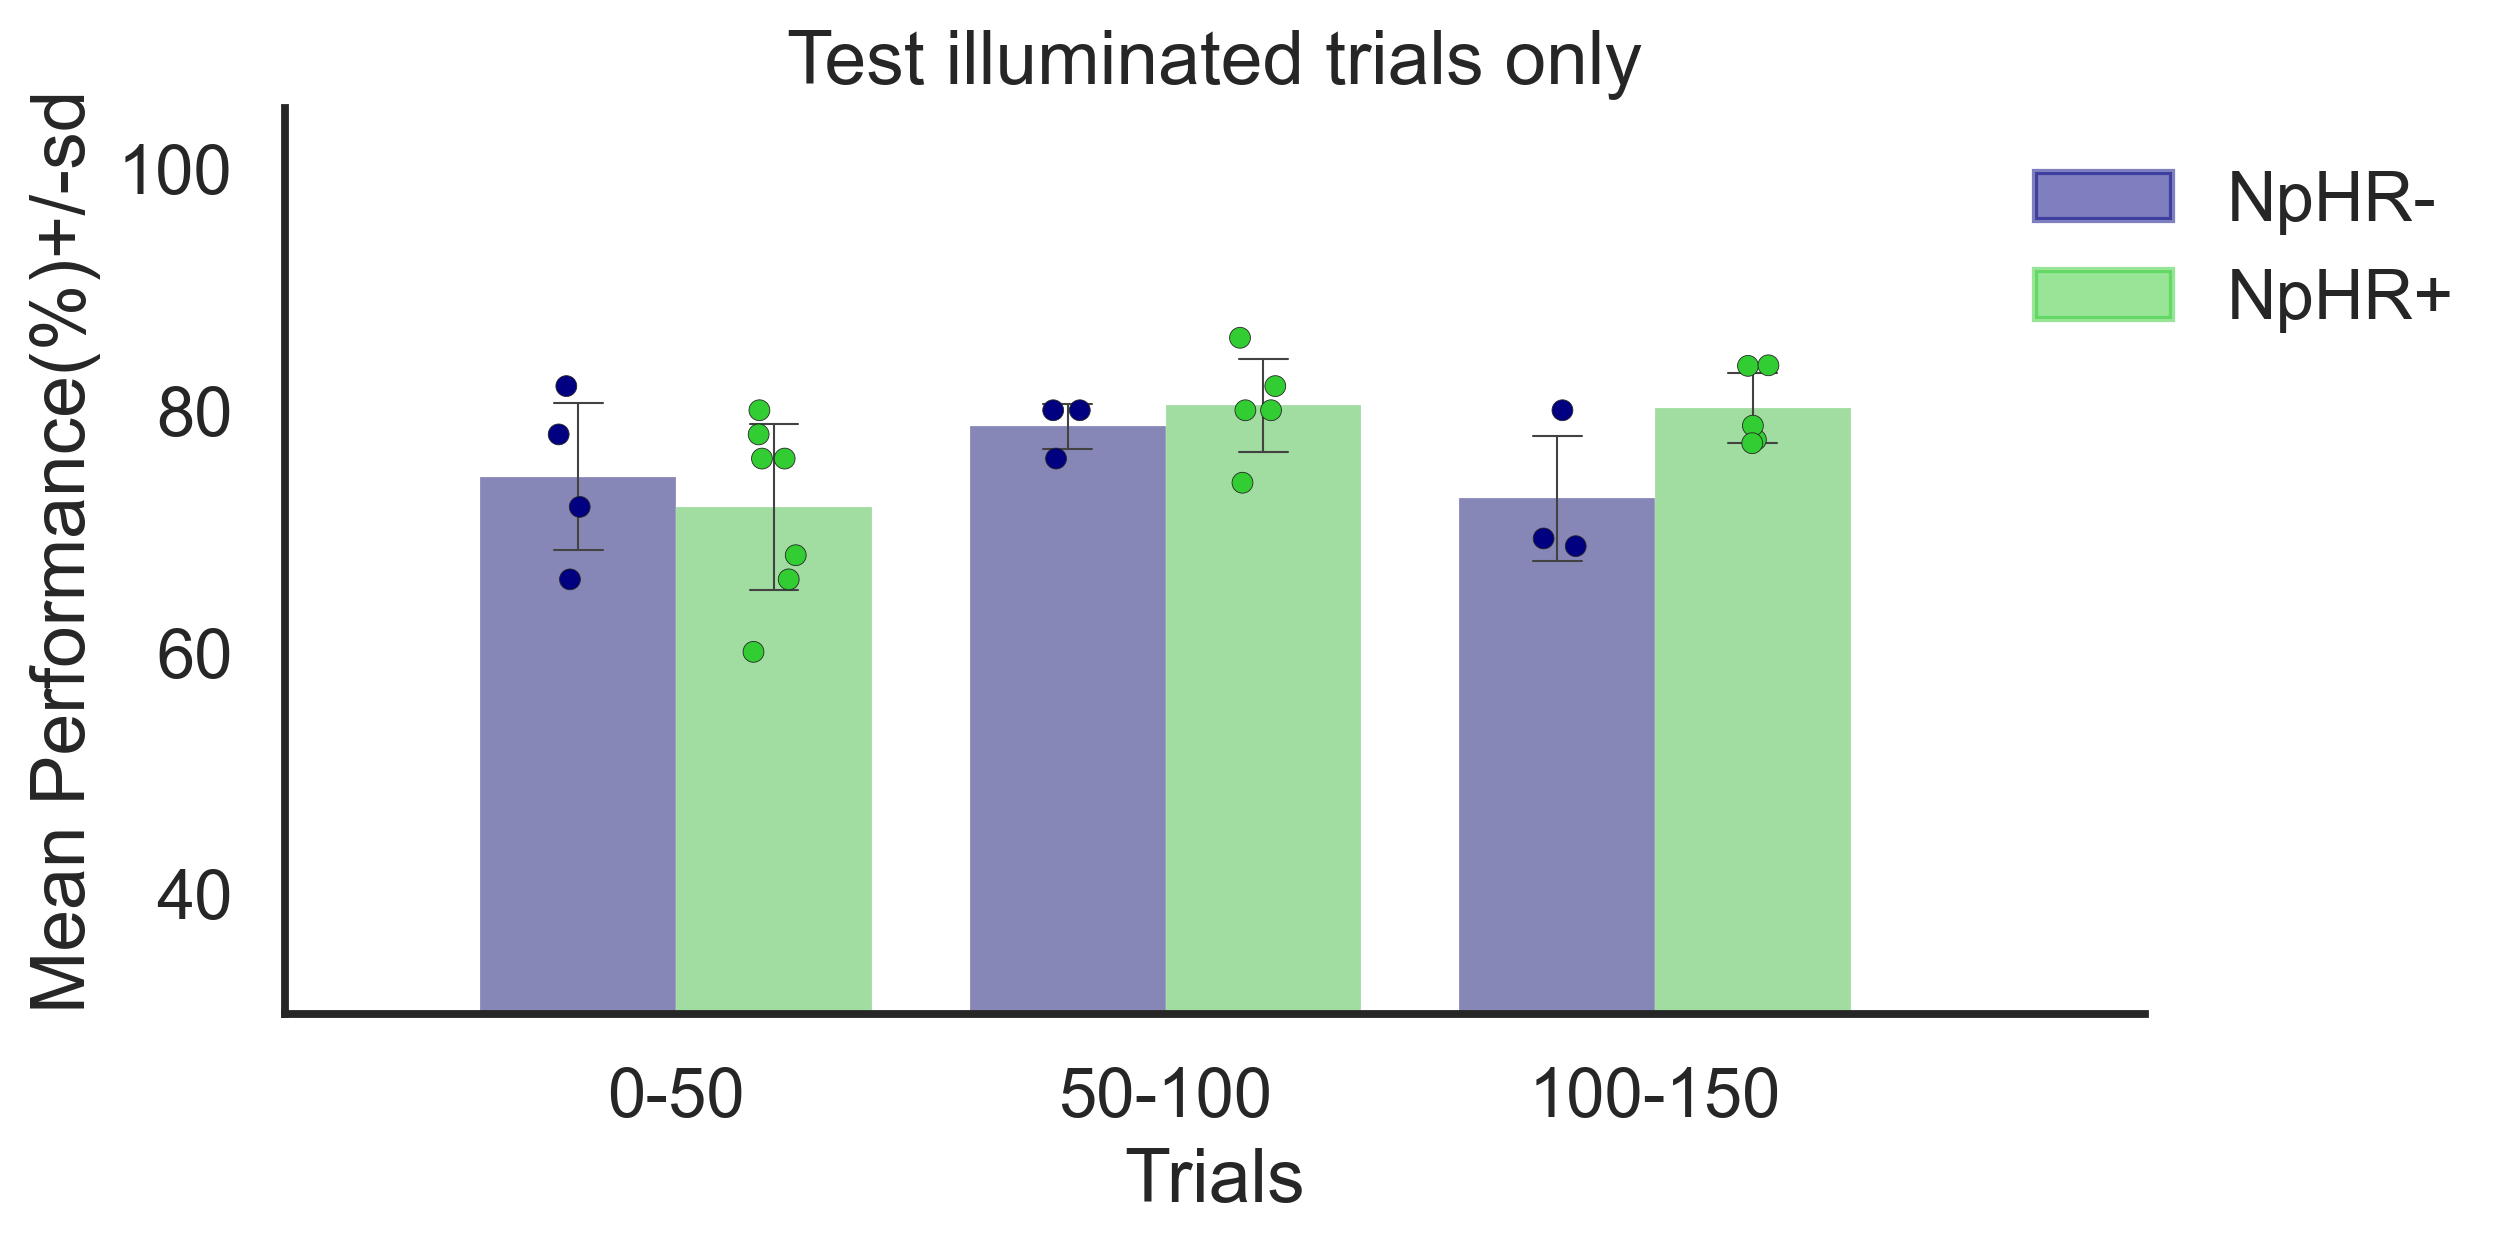

In [58]:
# Collect trials with the test run illuminated
df = par_perf[par_perf['stim'] == 3].drop(index=[3,4]).reset_index()
print(df['rat'].unique())

# Remove one data point from NPHR1 (accidently has a 1 index)
i = df[(df['rat'] == 'NPHR1') & (df['index']==1)].index
df = df.drop(index=i)

sns.set(style="white", context='talk')
plt.figure(figsize=(8,4), dpi=300)

g = sns.stripplot(
    data=df, x='index', y='outcome', hue='group',
    jitter=.1, alpha=1, s=5, dodge=True, linewidth=.2,
    palette=['navy', 'limegreen']
)
    
# Show means. 1st color=0, 2nd color=sample, 3rd color=test
sns.barplot(
    data=df, x='index', y='outcome', hue='group', 
    alpha=.5, ci='sd', errwidth=.5, capsize=.1, linewidth=.1,
    palette=['navy', 'limegreen']
)

g.set(
    xlim=(-.8,3), ylim=(30,105),
    ylabel=' Mean Performance(%)+/-sd', xlabel='Trials',
    title='Test illuminated trials only'
)

g.set_xticklabels(['0-50', '50-100', '100-150'], rotation=0)
g.legend_.remove()

ctrl_patch = mpatches.Patch(color='navy', label='NpHR-', alpha=.5)
nphr_patch = mpatches.Patch(color='limegreen', label='NpHR+', alpha=.5)

plt.legend(handles=[ctrl_patch, nphr_patch], frameon=False, loc='upper right', bbox_to_anchor=(1.2, 1))

sns.despine()
plt.show()

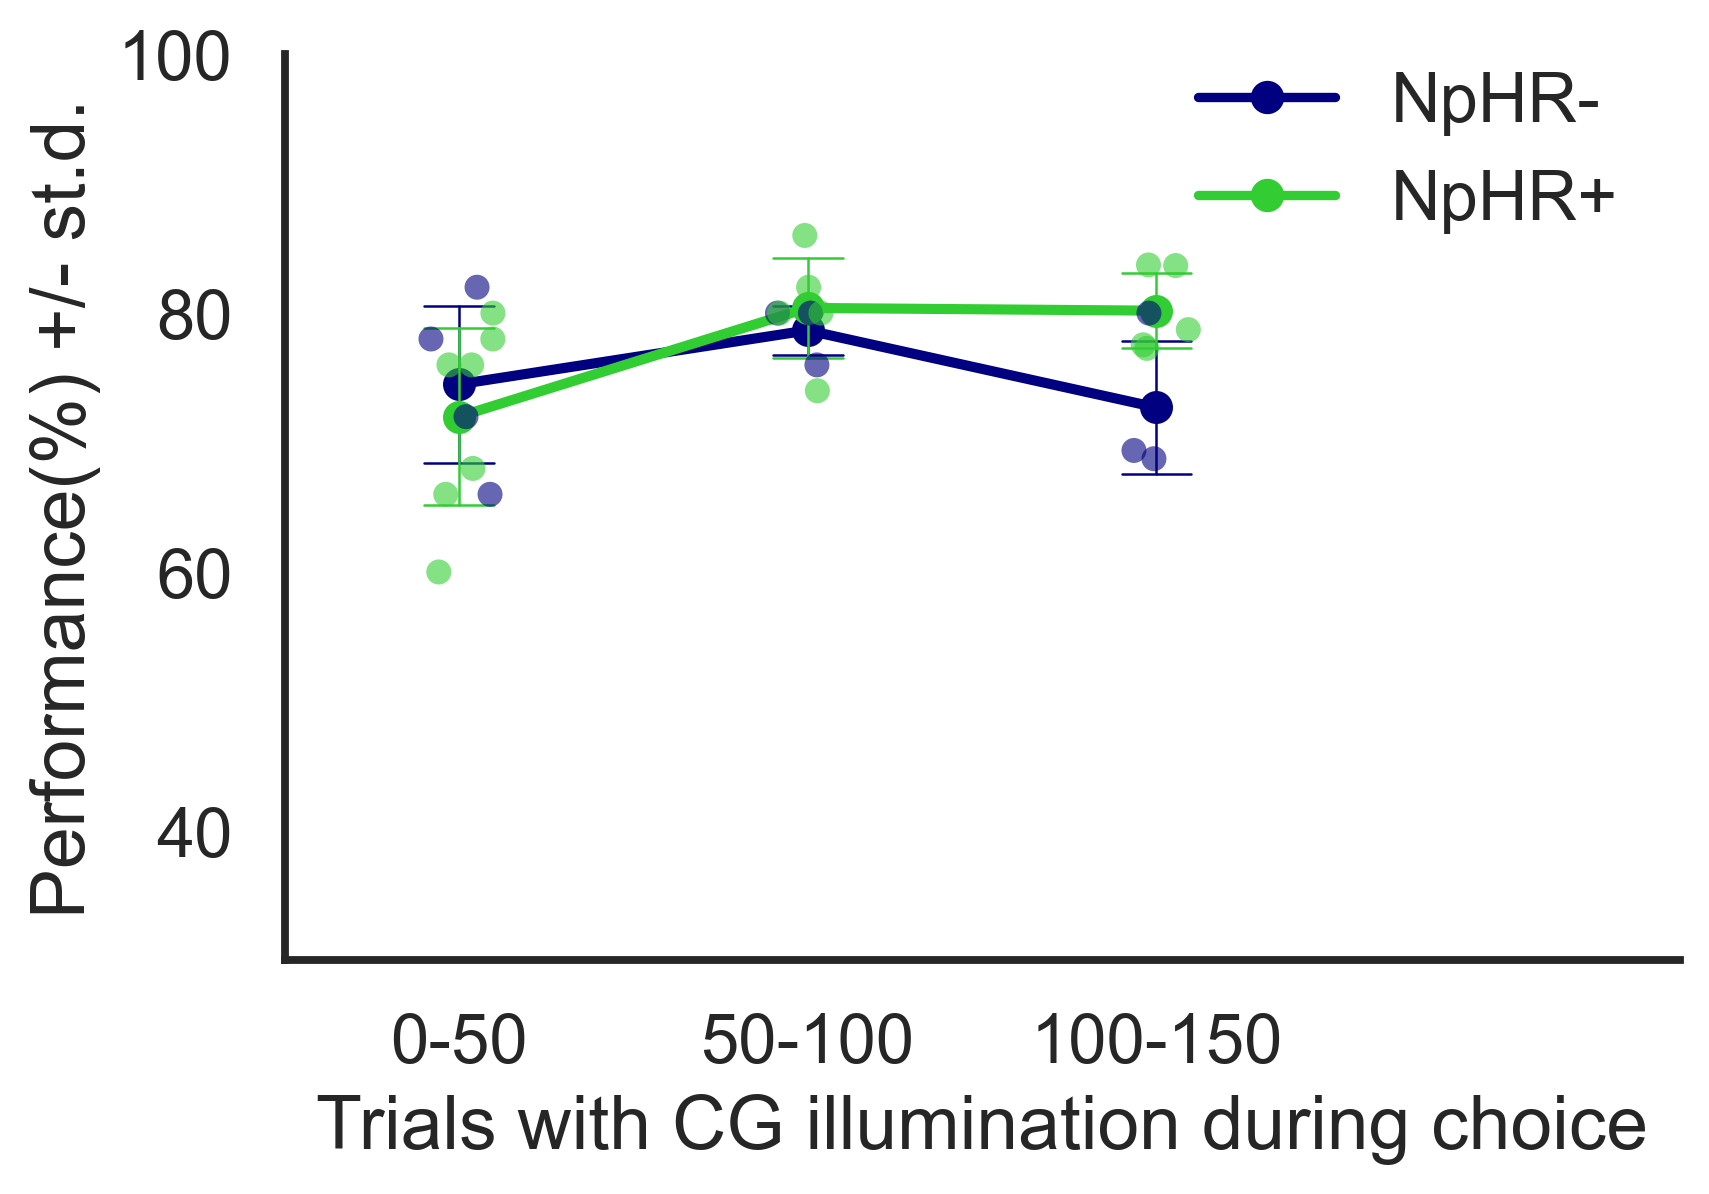

In [39]:
df = par_perf[par_perf['stim'] == 3].drop(index=[3,4])

# ------------------------------------  PLOT   ----------------------------------------
sns.set(style="white", context='talk')
plt.figure(figsize=(6,4), dpi=300)

g = sns.stripplot(
    x=df.index, y='outcome', hue='group', data=df,
    palette=['navy', 'limegreen'],
    jitter=.1, alpha=.6, s=6
)
    
# Show means. 1st color=control, 2nd color=nphr
a = sns.pointplot(
    x=df.index, y='outcome', hue='group', data=df, 
    dodge=False, join=True,            
    markers="o", scale=.6,  alpha=.8,
    ci='sd', errwidth=.6, capsize=.2,
    palette=['navy', 'limegreen']
)

g.set(
    xlim=(-0.5,3.5), ylim=(30,100),
    ylabel='Performance(%) +/- st.d.', xlabel='Trials with CG illumination during choice',
    #title='Performance under CG silencing during choice, across the stimulation protocol'
)

g.set_xticklabels(['0-50','50-100', '100-150'], rotation=0)

# ------------------------------------- LEGEND -------------------------------------------- 
g.legend_.remove()

control_line = mlines.Line2D([], [], color='navy', marker='o', markersize=7, label='NpHR-')
nphr_line = mlines.Line2D([], [], color='limegreen', marker='o', markersize=7, label='NpHR+')
plt.legend(handles=[control_line, nphr_line], frameon=False, loc='upper right', bbox_to_anchor=(1, 1.05))

sns.despine()
plt.show()

In [59]:
df[df['stim'] == 3]

,index,outcome,group,rat,stim
0,0,66.000000,control,BRIOSA_CTRL3,3.0
1,1,80.000000,control,BRIOSA_CTRL3,3.0
2,2,69.387755,control,BRIOSA_CTRL3,3.0
3,0,82.000000,control,DENGOSO_CTRL2,3.0
4,1,80.000000,control,DENGOSO_CTRL2,3.0
5,2,80.000000,control,DENGOSO_CTRL2,3.0
6,0,78.000000,control,MESTRE_CTRL1,3.0
7,0,72.000000,control,ROCKY_CTRL6,3.0
8,1,76.000000,control,ROCKY_CTRL6,3.0
9,2,68.750000,control,ROCKY_CTRL6,3.0


# 4.
***
### Comparing the performance across trials during CG silencing (SAMPLE) for both groups - control and NpHR
***

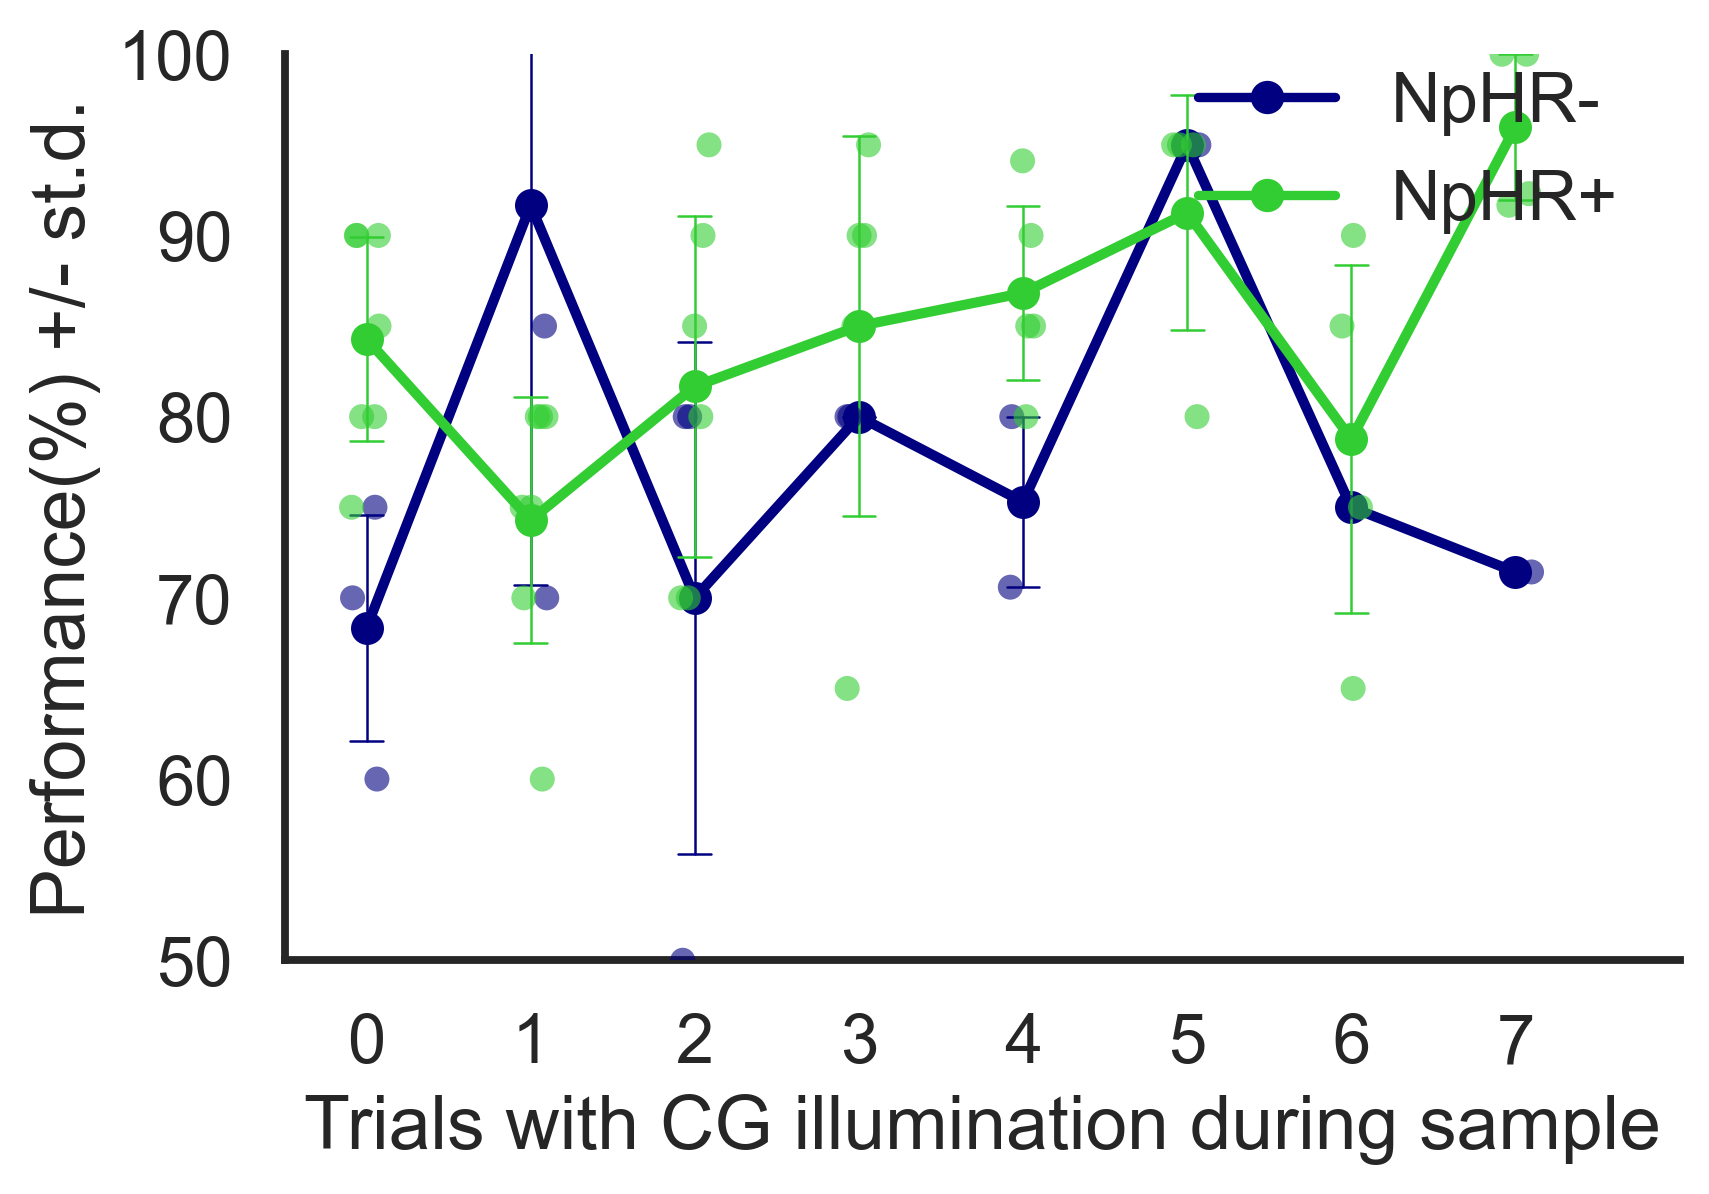

In [40]:
df = par_perf[par_perf['stim'] == 1] #.drop(index=[3])

# ------------------------------------  PLOT   ----------------------------------------
sns.set(style="white", context='talk')
plt.figure(figsize=(6,4), dpi=300)

g = sns.stripplot(
    x=df.index, y='outcome', hue='group', data=df,
    palette=['navy', 'limegreen'],
    jitter=.1, alpha=.6, s=6
)
    
# Show means. 1st color=control, 2nd color=nphr
a = sns.pointplot(
    x=df.index, y='outcome', hue='group', data=df, 
    dodge=False, join=True,            
    markers="o", scale=.6,  alpha=.8,
    ci='sd', errwidth=.6, capsize=.2,
    palette=['navy', 'limegreen']
)

g.set(
    xlim=(-0.5,8), ylim=(50,100),
    ylabel='Performance(%) +/- st.d.', xlabel='Trials with CG illumination during sample',
    #title='Performance under CG silencing during choice, across the stimulation protocol'
)

#g.set_xticklabels(['0-50','50-100', '100-150'], rotation=0)

# ------------------------------------- LEGEND -------------------------------------------- 
g.legend_.remove()

control_line = mlines.Line2D([], [], color='navy', marker='o', markersize=7, label='NpHR-')
nphr_line = mlines.Line2D([], [], color='limegreen', marker='o', markersize=7, label='NpHR+')
plt.legend(handles=[control_line, nphr_line], frameon=False, loc='upper right', bbox_to_anchor=(1, 1.05))

sns.despine()
plt.show()

# 5.
***
### Comparing the performance across trials with no CG silencing for both groups - control and NpHR
***

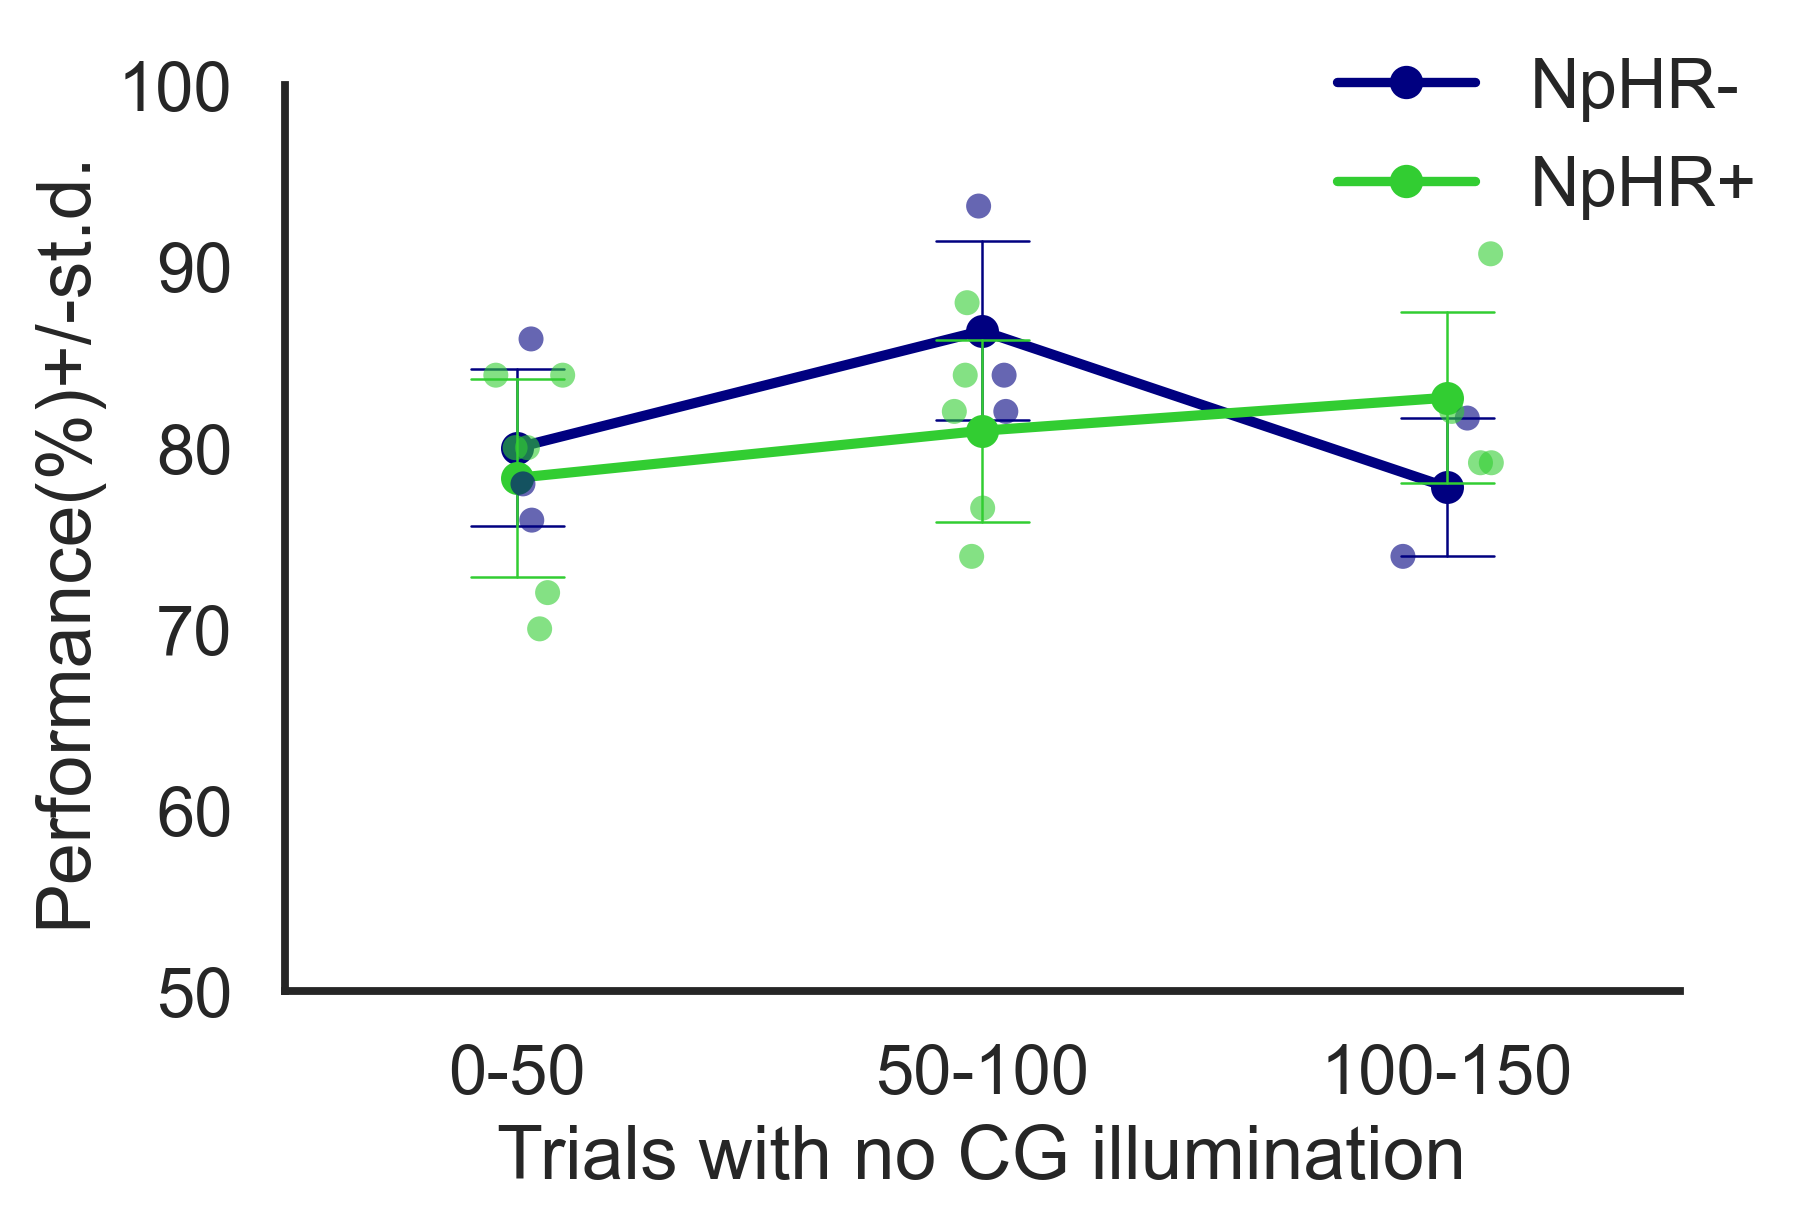

In [13]:
df = par_perf[par_perf['stim'] == 0].drop(index=[3])
    
sns.set(style="white", context='talk')
plt.figure(figsize=(6,4), dpi=300)

g = sns.stripplot(
    x=df.index, y='outcome', hue='group', data=df,
    palette=['navy', 'limegreen'],
    jitter=.1, alpha=.6, s=6
)
    
# Show means. 1st color=control, 2nd color=nphr
a = sns.pointplot(
    x=df.index, y='outcome', hue='group', data=df, 
    dodge=False, join=True,            
    markers="o", scale=.6,  alpha=.8,
    ci='sd', errwidth=.6, capsize=.2,
    palette=['navy', 'limegreen'], legend=True
)

g.set(
    xlim=(-0.5,2.5), ylim=(50,100),
    ylabel='Performance(%)+/-st.d.', xlabel='Trials with no CG illumination',
    #title='Performance under no silencing during choice, across the stimulation protocol'
)

g.set_xticklabels(['0-50','50-100', '100-150'], rotation=0)

# ------------------------------------- LEGEND -------------------------------------------- 
g.legend_.remove()

control_line = mlines.Line2D([], [], color='navy', marker='o', markersize=7, label='NpHR-')
nphr_line = mlines.Line2D([], [], color='limegreen', marker='o', markersize=7, label='NpHR+')
plt.legend(handles=[control_line, nphr_line], frameon=False, loc='upper right', bbox_to_anchor=(1.1, 1.1))

sns.despine()
plt.show()

# 6 .
***
### Comparing the drop in performance under stimulation during choice for the first block of 50 trials and the performance during the pre-stimulation period - NpHR+ and NpHR-
***

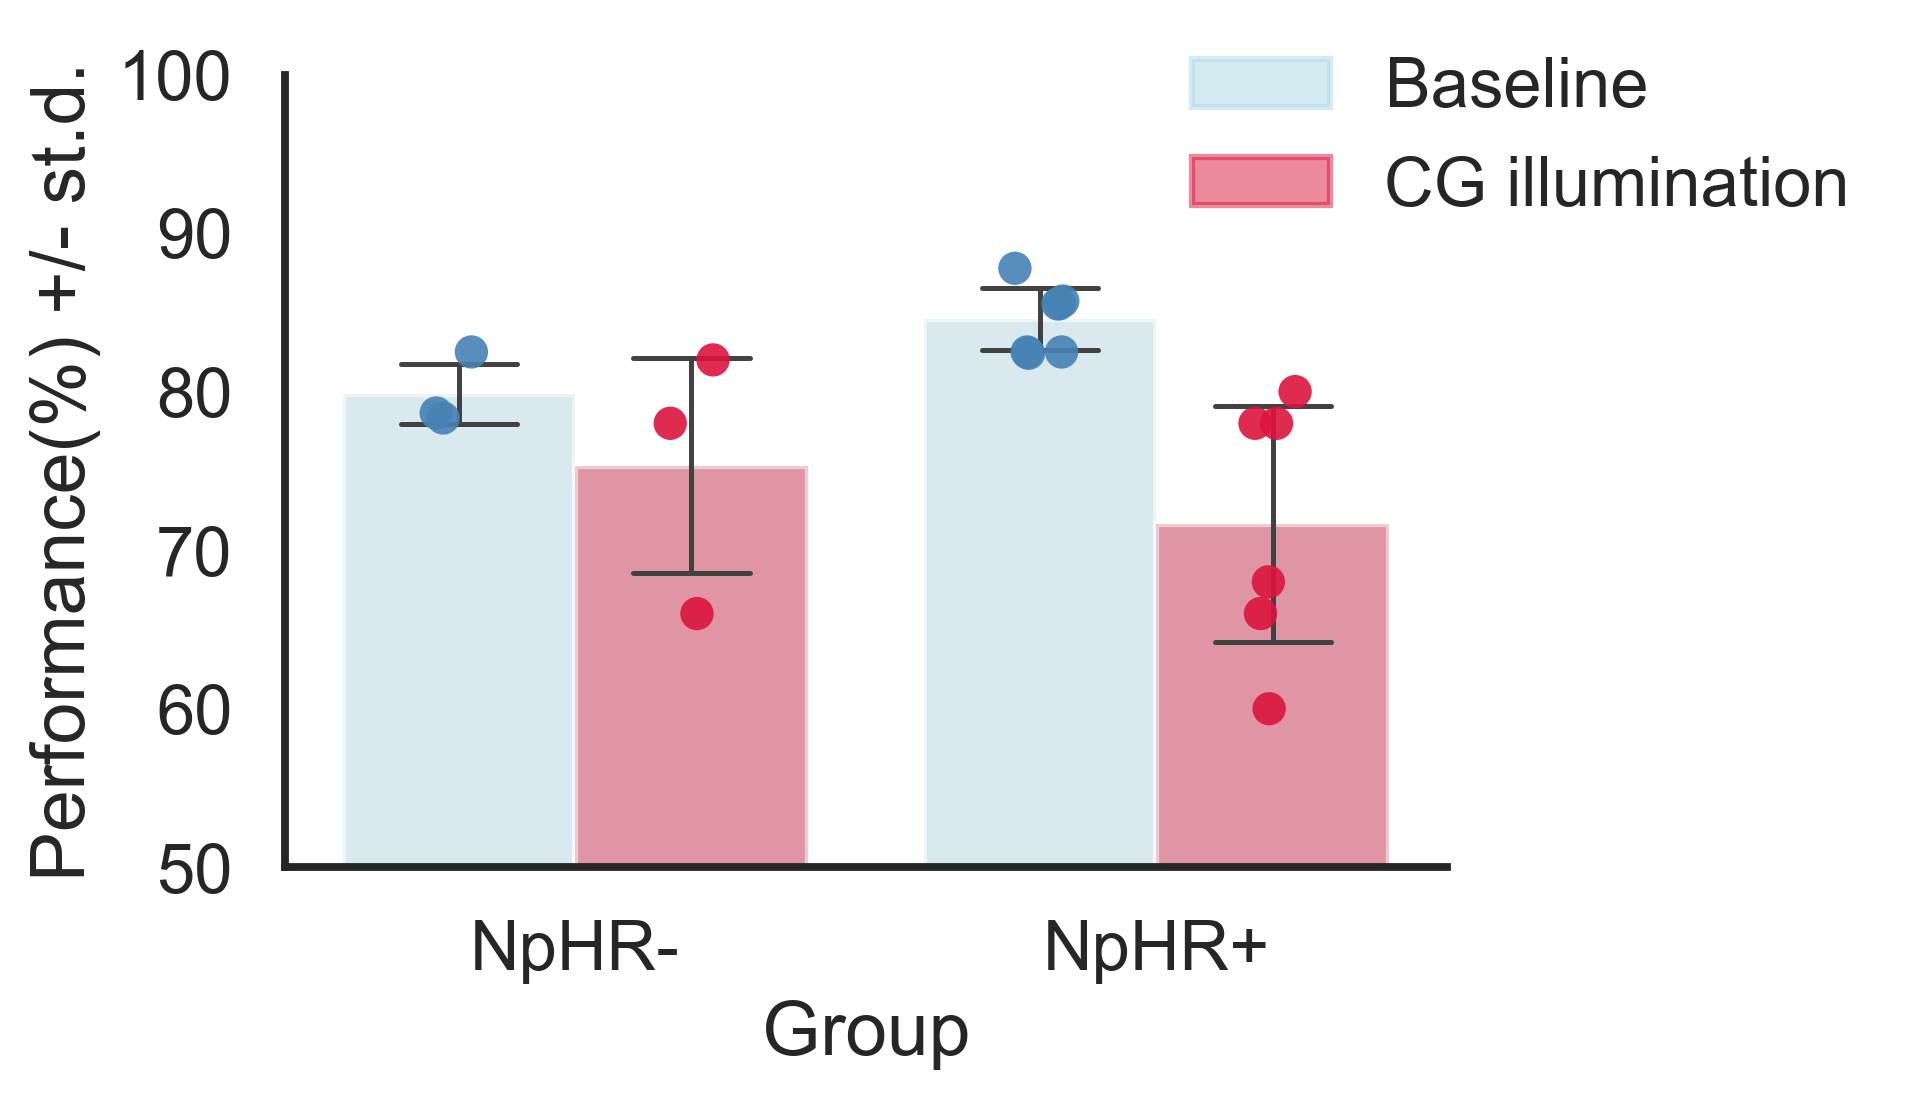

In [14]:
df = par_perf[(par_perf['stim'] == 3)]
df = df[df.index==0]

#Calculate the pre-stimulation performance per rat (multiplied by 100)
# Drop non-necessary columns from prestim_perf in order to concatenate with df 
x = prestim.groupby(['group','rat']).sum()
y = prestim.groupby(['group', 'rat']).count()
prestim_perf = (x/y)
prestim_perf['outcome']=(prestim_perf['outcome']*100)
prestim_perf = prestim_perf.reset_index()
prestim_perf = prestim_perf[prestim_perf['rat']!='NPHR#3'].drop(['sample', 'session', 'trial_nr_stim'], axis=1)

df = pd.concat([df,prestim_perf])
#df['stim'] = df['stim'].mask(df['stim']==3, 0)
#--------------------------------------------------------------------------------------------------------------------------#
sns.set(style="white", context='talk')
plt.figure(figsize=(5,3.5), dpi=300)
                             
a = sns.stripplot(
    x='group', y='outcome', hue='stim',data=df,
    dodge=.8, jitter=.09, alpha=.9, s=8, palette=['steelblue', 'crimson'],
)
# Show means
sns.barplot(
    x='group', y='outcome', hue='stim', data=df,            
    ci="sd", errwidth=1.2, capsize=.2, alpha=.5, palette=['lightblue', 'crimson']
)

a.set(
    ylabel='Performance(%) +/- st.d.', xlabel='Group',
    ylim=(50, 100), xlim=(-.5, 1.5)
)


a.set_xticklabels(labels=['NpHR-', 'NpHR+'], rotation=0)

#--------------------- LEGEND -------------------#
a.legend_.remove()
prestim_patch = mpatches.Patch(color='lightblue', label='Baseline', alpha=.5)
test_stim_patch = mpatches.Patch(color='crimson', label='CG illumination', alpha=.5)
plt.legend(handles=[prestim_patch, test_stim_patch], frameon=False, loc='upper right', bbox_to_anchor=(1.4, 1.1))

sns.despine()
plt.show()

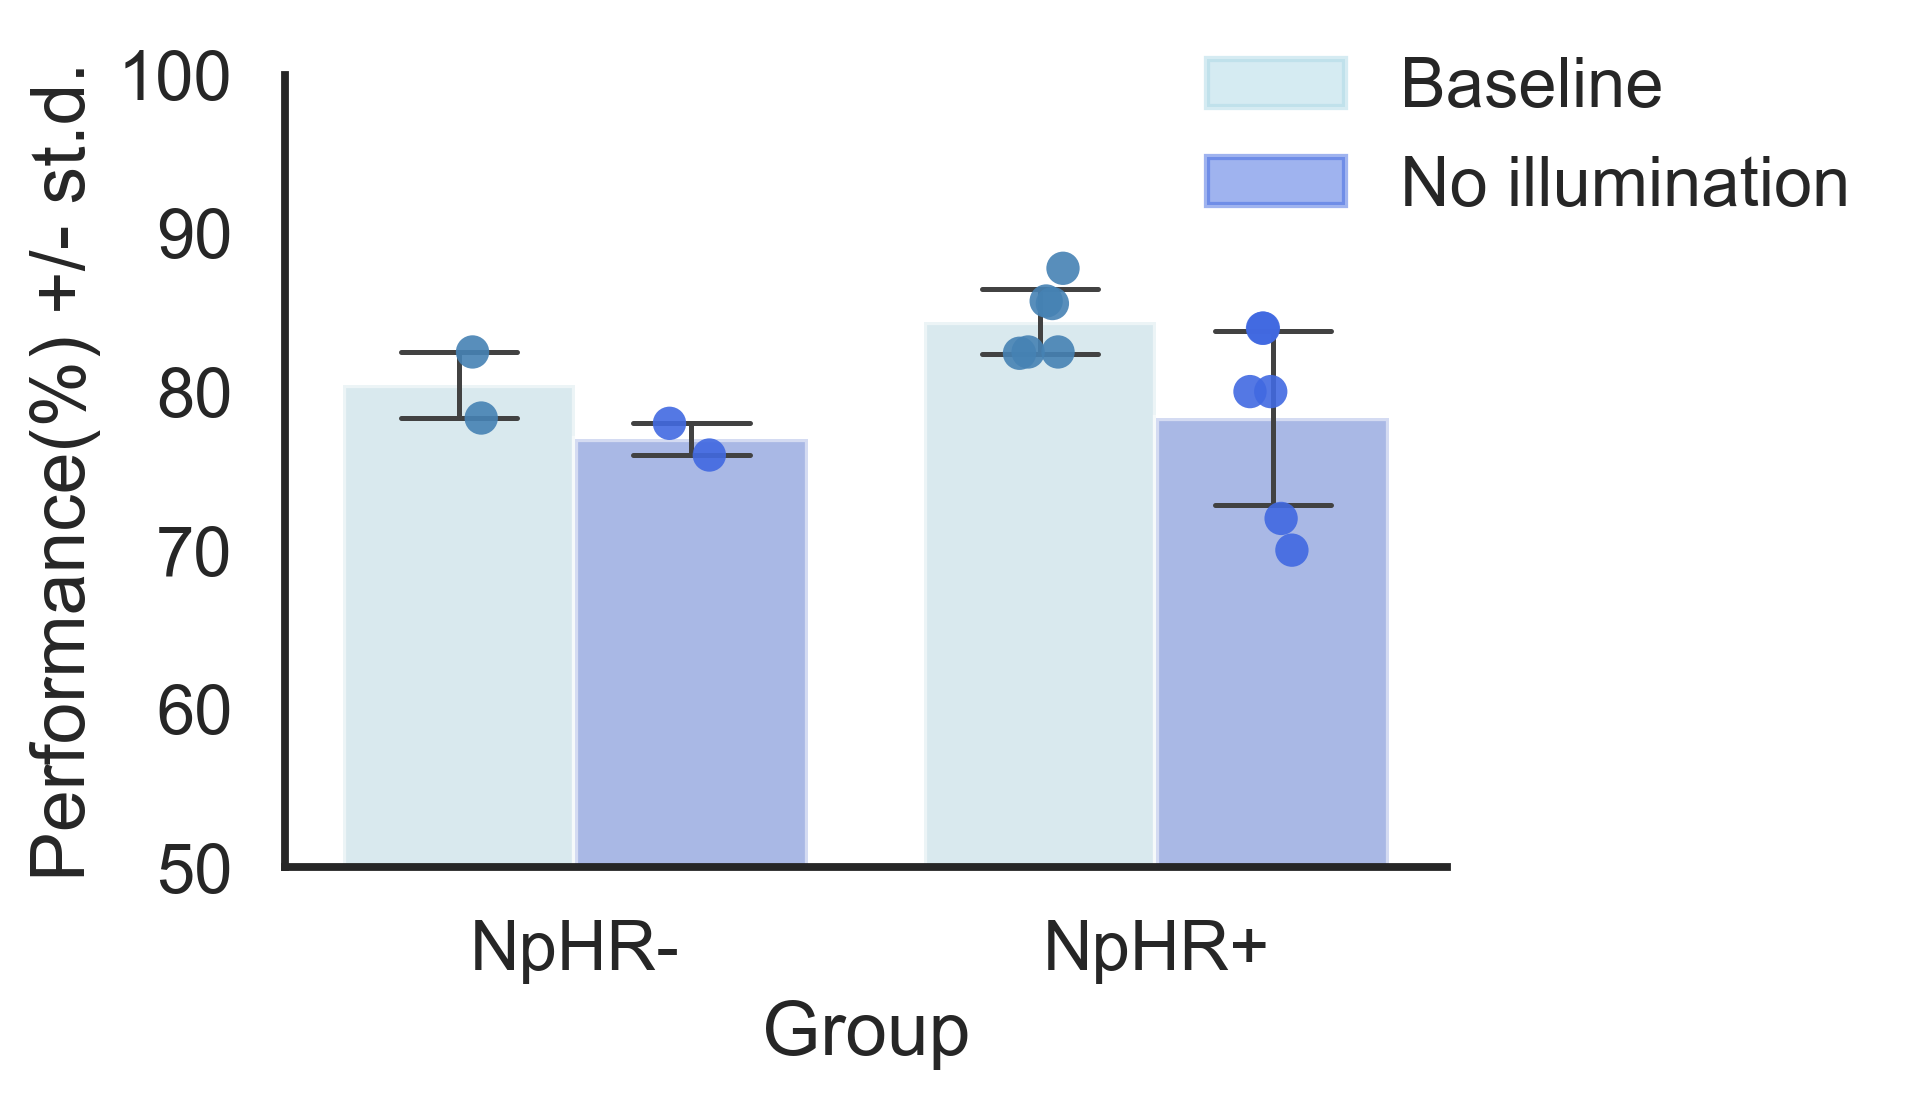

In [18]:
df = par_perf[(par_perf['stim'] == 0)]
df = df[df.index==0]

#Calculate the pre-stimulation performance per rat (multiplied by 100)
# Drop non-necessary columns from prestim_perf in order to concatenate with df 
x = prestim.groupby(['group','rat']).sum()
y = prestim.groupby(['group', 'rat']).count()
prestim_perf = (x/y)
prestim_perf['outcome']=(prestim_perf['outcome']*100)
prestim_perf = prestim_perf.reset_index()
prestim_perf = prestim_perf[prestim_perf['rat']!='NPHR#3'].drop(['sample', 'session', 'trial_nr_stim'], axis=1)

df = pd.concat([df,prestim_perf])
#--------------------------------------------------------------------------------------------------------------------------#
sns.set(style="white", context='talk')
plt.figure(figsize=(5,3.5), dpi=300)
                             
a = sns.stripplot(
    x='group', y='outcome', hue='stim',data=df,
    dodge=.8, jitter=.09, alpha=.9, s=8, palette=['steelblue', 'royalblue'],
)
# Show means
sns.barplot(
    x='group', y='outcome', hue='stim', data=df,            
    ci="sd", errwidth=1.2, capsize=.2, alpha=.5, palette=['lightblue', 'royalblue']
)

a.set(
    ylabel='Performance(%) +/- st.d.', xlabel='Group',
    ylim=(50, 100), xlim=(-.5, 1.5)
)


a.set_xticklabels(labels=['NpHR-', 'NpHR+'], rotation=0)

#--------------------- LEGEND -------------------#
a.legend_.remove()
prestim_patch = mpatches.Patch(color='lightblue', label='Baseline', alpha=.5)
test_stim_patch = mpatches.Patch(color='royalblue', label='No illumination', alpha=.5)
plt.legend(handles=[prestim_patch, test_stim_patch], frameon=False, loc='upper right', bbox_to_anchor=(1.4, 1.1))

sns.despine()
plt.show()